In [ ]:
import gurobipy as gp
import pandas as pd
from gurobipy import GRB
import numpy as np
import random
import time as tm
import matplotlib.pyplot as plt

In [2]:
PV_cf = pd.read_csv('0-data/pv_scens_2.csv')
PV_cf = PV_cf.drop(columns =['Unnamed: 0'])

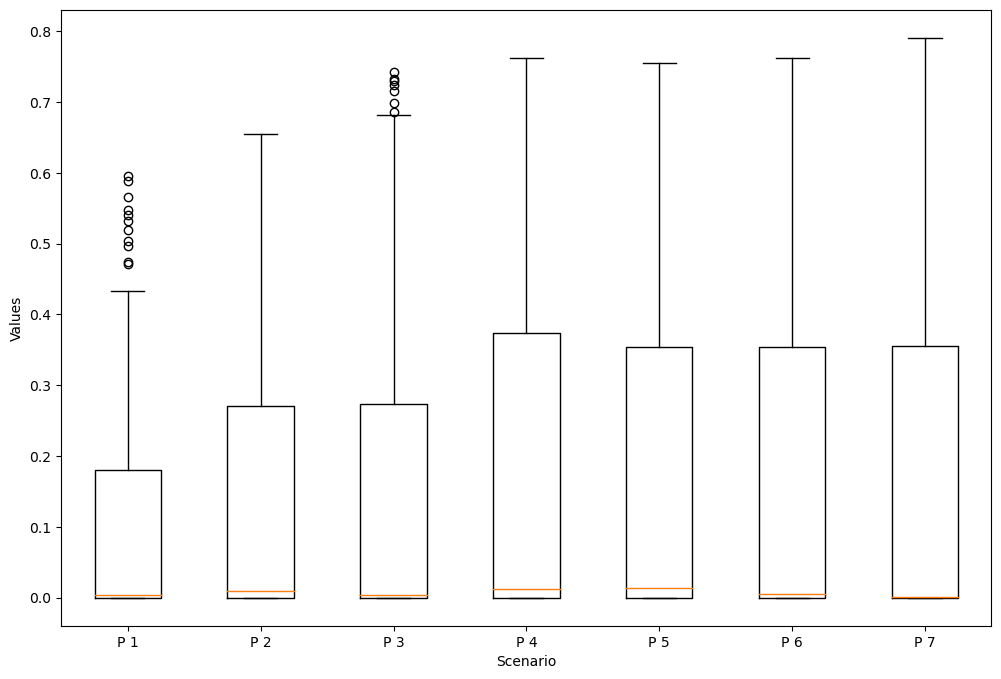

In [3]:
boxplot_data_scenarios = [PV_cf.iloc[i, :].values for i in range(PV_cf.shape[0])]

plt.figure(figsize=(12, 8))
plt.boxplot(boxplot_data_scenarios, labels=[f'P {i+1}' for i in range(PV_cf.shape[0])])
plt.xlabel('Scenario')
plt.ylabel('Values')
plt.show()

In [4]:
Demand_org = pd.read_csv('0-data/demand_scens.csv')
Demand_org = Demand_org.drop(columns =['Unnamed: 0'])

In [5]:
demand_coeff = 0.08

In [6]:
Demand = Demand_org * demand_coeff

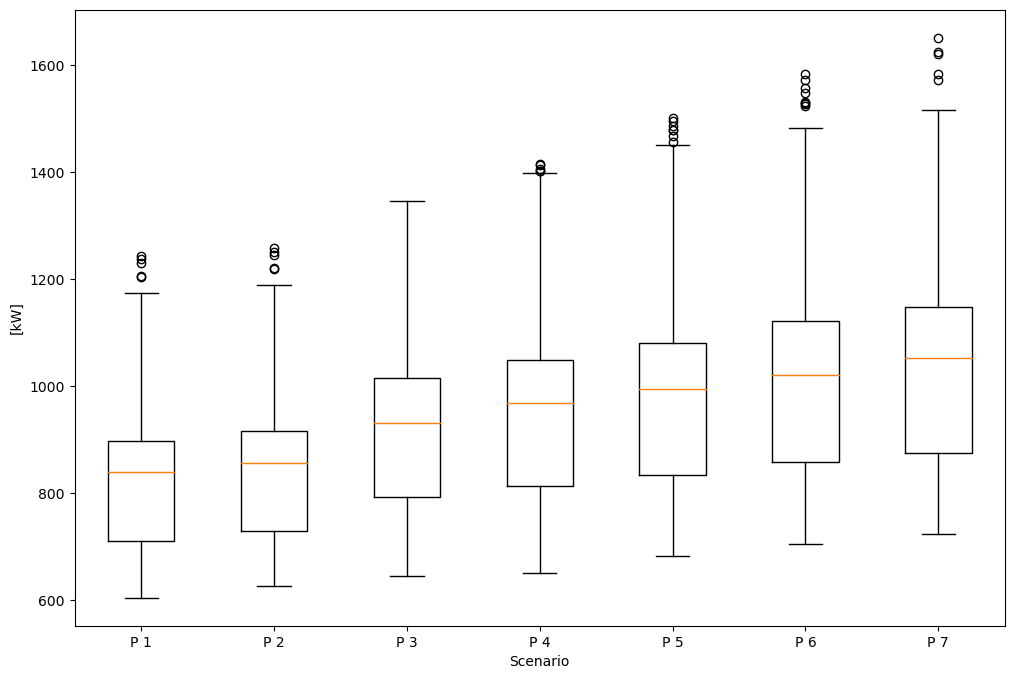

In [7]:
boxplot_Demand_scenarios = [Demand.iloc[i, :].values for i in range(Demand.shape[0])]

plt.figure(figsize=(12, 8))
plt.boxplot(boxplot_Demand_scenarios, labels=[f'P {i+1}' for i in range(Demand.shape[0])])
plt.xlabel('Scenario')
plt.ylabel('[kW]')
plt.show()

In [8]:
cf_pv = PV_cf.T
demand = Demand.T
probabilities = [0.1, 0.15, 0.15, 0.2, 0.15, 0.15, 0.1]

In [9]:
def stage_two (n_PV,n_DE,n_BESS):

    n_PV = round(n_PV)
    n_DE = round(n_DE)
    n_BESS = round(n_BESS)
    
    time = [*range(cf_pv.shape[0])]
    scenario = [*range(cf_pv.shape[1])]
    
    storage = ['BESS']
    generator = ['DE']
    renewable=['PV']
    
    c_PV_rated = 1 #kW
    c_DE_rated = 1000 #kW
    c_BESS_rated = 3000 #kWh
    
    pi_D_DE = 0.016 #$/kWh
    pi_CO2_DE = 25 #$/t_CO2
    phi_CO2_DE = 0.27 #% kg/kWh
    teta_eff_DE = 0.31 #%
    
    cf_DE_max = 1
    cf_DE_min = 0.2
    
    p_max_CH = 750 #kw 4 hours
    p_min_CH = 0 #kw
    
    p_max_DCH = 750 #kw 4 hours
    p_min_DCH = 0 #kw
    
    SoC_max = 1
    SoC_min = 0.1
    
    eta_CH = 0.90
    eta_DCH = 0.90
     
    VoLL = 1000 #$/kWh

    try:
        m = gp.Model()

        p_DE = m.addVars(generator, time, scenario, vtype=GRB.CONTINUOUS, name='DEs active power')
        p_PV = m.addVars(renewable, time, scenario, vtype=GRB.CONTINUOUS, name='PV active power')
        p_CH = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS charge')
        p_DCH = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS discharge')
        e_BESS = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS energy level')

        u_DE = m.addVars(generator, time, scenario, vtype=GRB.BINARY, name='DEs production status')
        u_BESS = m.addVars(storage, time, scenario, vtype=GRB.BINARY, name='Charging/Discharging status')

        enns = m.addVars(time, scenario, vtype=GRB.CONTINUOUS, name='electricity needed but not supplied')


    # DE
        capacity_DE = n_DE * c_DE_rated
        
        power_limit_1 = m.addConstrs(p_DE["DE", t, s] <= capacity_DE * u_DE["DE", t, s] * cf_DE_max
                                     for t in time
                                     for s in scenario
                                     )
        
        power_limit_2 = m.addConstrs(p_DE["DE", t, s] >= capacity_DE * u_DE["DE", t, s] * cf_DE_min
                                     for t in time
                                     for s in scenario
                                     )
    
    
    
            #PV
    
        capacity_PV = n_PV * c_PV_rated
        capacity_factor_pv = m.addConstrs(p_PV["PV", t, s] == capacity_PV * cf_pv.iloc[t,s]
                                          for t in time
                                          for s in scenario
                                          )
    
            # BESS
        capacity_BESS = n_BESS * c_BESS_rated
        
        initial_soc = m.addConstrs(e_BESS['BESS', 0, s] == 0.4 * capacity_BESS for s in scenario)
        
        max_CH_BESS_1 = m.addConstrs(p_CH["BESS", t, s] <= u_BESS ["BESS", t, s] * p_max_CH * n_BESS
                                     for t in time
                                     for s in scenario
                                     )
        
        max_CH_BESS_2 = m.addConstrs(p_CH["BESS", t, s] >= u_BESS ["BESS", t, s] * p_min_CH * n_BESS
                                     for t in time
                                     for s in scenario
                                     )
        
        max_DCH_BESS_1 = m.addConstrs(p_DCH["BESS", t, s] <= (1-u_BESS ["BESS", t, s]) * p_max_DCH * n_BESS
                                      for t in time
                                      for s in scenario
                                      )
        
        max_DCH_BESS_2 = m.addConstrs(p_DCH["BESS", t, s] >= (1-u_BESS ["BESS", t, s]) * p_min_DCH * n_BESS
                                      for t in time
                                      for s in scenario
                                      )
        
        SoC_BESS_1 = m.addConstrs(e_BESS["BESS", t, s] <= capacity_BESS * SoC_max
                                  for t in time
                                  for s in scenario
                                  )
        
        SoC_BESS_2 = m.addConstrs(e_BESS["BESS", t, s] >= capacity_BESS * SoC_min
                                  for t in time
                                  for s in scenario
                                  )
        
        energy_BESS = m.addConstrs(e_BESS["BESS", t, s] == e_BESS["BESS", t-1, s] + (p_CH["BESS", t, s] * eta_CH - p_DCH["BESS", t, s]/eta_DCH)
                                   for t in [*range(1,len(time))]
                                   for s in scenario
                                   )
        
        
        energy_BESS_constraints = {}
        num_days = len(time) // 24
        for p in range(1, num_days+1):
            end_hour = p * 24 - 1
            energy_BESS_constraints[p] = m.addConstrs(
                e_BESS["BESS", 0, s] == e_BESS["BESS", end_hour, s] for s in scenario)
            
    
        meet_demand_1 = m.addConstrs(p_DE['DE', t, s] +
                                     p_PV['PV', t, s] +
                                     p_DCH['BESS', t, s] +
                                     enns[t, s] -
                                     p_CH['BESS', t, s] ==
                                     demand.iloc[t,s]
                                     for t in time
                                     for s in scenario
                                     )
        
        net_operating_cost = m.setObjective(gp.quicksum(probabilities[s] * (
                (pi_D_DE+pi_CO2_DE/1000*phi_CO2_DE) * (1/teta_eff_DE) * gp.quicksum(p_DE['DE', t, s] for t in time) +
                gp.quicksum(enns[t, s] * VoLL for t in time))
                                                        for s in scenario)
                                            , GRB.MINIMIZE)
            
            
        m.setParam('OutputFlag', 0)
        m.Params.MIPGap = 0.02
        m.Params.TimeLimit = 600
        m.optimize()
        obj_2 = m.objVal

        return obj_2
    except:
        return np.inf

In [10]:
T_period = len([*range(cf_pv.shape[0])])

CAPEX_DE = 400 #$/kW
LT_DE = 19 #y
T_LT_DE = LT_DE * 365 * 24
C_CAPEX_DE = CAPEX_DE * T_period/T_LT_DE

CAPEX_BESS = 353 #$/kWh Megapack Tesla
LT_BESS = 13 #y
T_LT_BESS = LT_BESS * 365 * 24
C_CAPEX_BESS = CAPEX_BESS * T_period/T_LT_BESS

CAPEX_PV = 600 #$/kW
LT_PV = 20 #y
T_LT_PV = LT_PV * 365 * 24
C_CAPEX_PV = CAPEX_PV * T_period/T_LT_PV

c_PV_rated = 1 #kWp
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh

In [19]:
C_CAPEX_DE*1000*0 + C_CAPEX_PV * 3936 + C_CAPEX_BESS * 3000* 7

22629.39515279241

In [12]:
T_period = len([*range(cf_pv.shape[0])])

CAPEX_DE = 400 #$/kW
LT_DE = 19 #y
T_LT_DE = LT_DE * 365 * 24
C_CAPEX_DE = CAPEX_DE * T_period/T_LT_DE

CAPEX_BESS = 353 #$/kWh Megapack Tesla
LT_BESS = 13 #y
T_LT_BESS = LT_BESS * 365 * 24
C_CAPEX_BESS = CAPEX_BESS * T_period/T_LT_BESS

CAPEX_PV = 600 #$/kW
LT_PV = 20 #y
T_LT_PV = LT_PV * 365 * 24
C_CAPEX_PV = CAPEX_PV * T_period/T_LT_PV

c_PV_rated = 1 #kW
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh


def fitness_function(position):
    PV_fc = C_CAPEX_PV #$/kW
    DE_fc = C_CAPEX_DE #$/kW
    BESS_fc = C_CAPEX_BESS #$/kWh


    investment_cost = position[0] * PV_fc * c_PV_rated + position[1] * DE_fc * c_DE_rated + position[2] * BESS_fc * c_BESS_rated
    variable_cost = stage_two(position[0], position[1], position[2])

    return variable_cost + investment_cost

def decreasing_inertia_weight(w_max, w_min, max_iter, current_iter):
    return w_max - (w_max - w_min) * (current_iter / max_iter)

def PSO(n_particles, dimensions, bounds, max_iter, cognitive_param, social_param, w_max, w_min, damping_factor,initial_guess):
    # Initialize the particles' positions and velocities
    random.seed(42)
    np.random.seed(42)
    positions = [np.array(initial_guess) for _ in range(n_particles)]

    # positions = [np.random.randint(bounds[:, 0], bounds[:, 1]) for _ in range(n_particles)]
    velocities = [np.random.uniform(bounds[:, 0], bounds[:, 1]) for _ in range(n_particles)]
    strt_time = tm.time()

    # Initialize the global best position and value
    global_best_pos = positions[0]
    global_best_val = fitness_function(global_best_pos)
    bestps=[]
    bestfit=[]
    iteration_positions = []
    best_particle_indices = []

    # Initialize the personal best positions and values for each particle
    personal_best_pos = positions.copy()
    personal_best_val = [fitness_function(pos) for pos in personal_best_pos]
    fitness_cache = {}

    # Iterate for the maximum number of iterations
    for i in range(max_iter):
        best_particle_idx = 0
        for j in range(n_particles):
            weight_param = decreasing_inertia_weight(w_max, w_min, max_iter, i)
            # Update the velocity
            velocities[j] = weight_param * velocities[j] + cognitive_param * random.uniform(0, 1) * (personal_best_pos[j] - positions[j]) + social_param * random.uniform(0, 1) * (global_best_pos - positions[j])

            velocities[j] *= damping_factor

            # Update the position
            positions[j] = positions[j] + velocities[j]
            positions[j] = np.round(positions[j])



            # Check if the position is within bounds, and adjust it if necessary
            for k in range(dimensions):
                if positions[j][k] < bounds[k][0]:
                    positions[j][k] = 2 * bounds[k][0] - positions[j][k]
                    velocities[j][k] *= -1
                elif positions[j][k] > bounds[k][1]:
                    positions[j][k] = 2 * bounds[k][1] - positions[j][k]
                    velocities[j][k] *= -1

            position_key = tuple(positions[j])
            if position_key in fitness_cache:
                fitness = fitness_cache[position_key]
            else:
                fitness = fitness_function(positions[j])
                fitness_cache[position_key] = fitness

            # Update the personal best position and value if the fitness function improves
            if fitness < personal_best_val[j]:
                personal_best_pos[j] = positions[j].copy()
                personal_best_val[j] = fitness
                bestfit.append(fitness)
                best_particle_idx = j


            # Update the global best position and value if the fitness function improves
            if fitness < global_best_val:
                global_best_pos = positions[j].copy()
                global_best_val = fitness
        bestps.append(global_best_val)
        iteration_positions.append(positions.copy())
        best_particle_indices.append(best_particle_idx)

        elapsed_time = tm.time() - strt_time
        remaining_time = elapsed_time * (max_iter - i - 1) / (i + 1)
        # print("Iteration:", i + 1, "of", max_iter)
        print("Iteration:", i + 1, "of", max_iter, "Estimated remaining time:",
              int(remaining_time // 60), "minutes and", int(remaining_time % 60), "seconds","; Elapsed time: ", int(elapsed_time//60), ' minutes')

    return global_best_pos, global_best_val, bestps, iteration_positions, best_particle_indices, bestfit

# 1-Results

## 1-1- DE+PV

In [13]:
bounds = np.array([[0, 1600], [0, 15], [0, 0]])

result1 = PSO(n_particles=6, dimensions=3, bounds=bounds, max_iter=100,
              cognitive_param=2, social_param=2, w_min=0.4, w_max=1, damping_factor=1, initial_guess = [0 , 0, 0])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-19
Iteration: 1 of 100 Estimated remaining time: 6 minutes and 15 seconds ; Elapsed time:  0  minutes
Iteration: 2 of 100 Estimated remaining time: 4 minutes and 30 seconds ; Elapsed time:  0  minutes
Iteration: 3 of 100 Estimated remaining time: 3 minutes and 54 seconds ; Elapsed time:  0  minutes
Iteration: 4 of 100 Estimated remaining time: 3 minutes and 36 seconds ; Elapsed time:  0  minutes
Iteration: 5 of 100 Estimated remaining time: 3 minutes and 23 seconds ; Elapsed time:  0  minutes
Iteration: 6 of 100 Estimated remaining time: 3 minutes and 14 seconds ; Elapsed time:  0  minutes
Iteration: 7 of 100 Estimated remaining time: 3 minutes and 7 seconds ; Elapsed time:  0  minutes
Iteration: 8 of 100 Estimated remaining time: 3 minutes and 2 seconds ; Elapsed time:  0  minutes
Iteration: 9 of 100 Estimated remaining time: 2 minutes and 57 seconds ; Elapsed time:  0  minutes
Iteration: 10 of 100

In [14]:
global_best_pos_1 =result1[0]
global_best_val_1 = result1[1]
global_best_fitness_1 = result1[2]
iteration_positions_1 = result1[3]
best_particle_indices_1 = result1[4]
bestfit_particle_1 = result1[5]

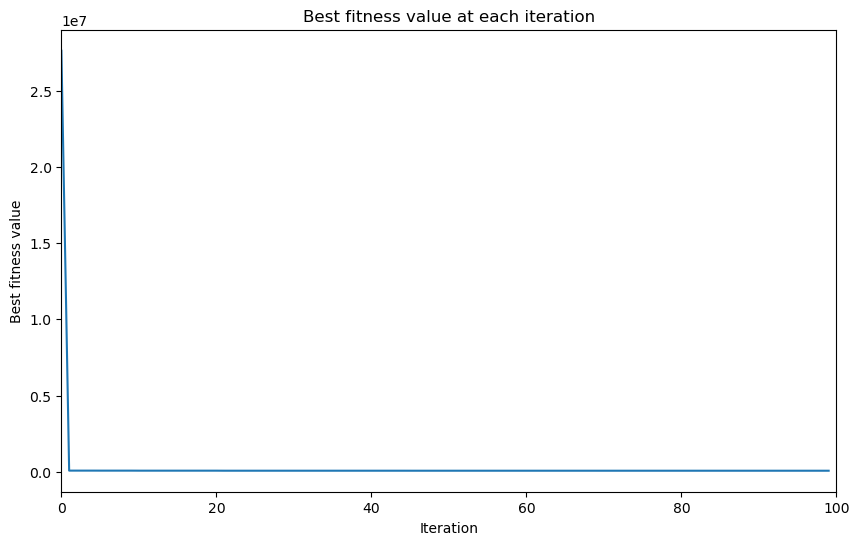

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, 100), global_best_fitness_1, linestyle='-')
plt.xlim(0,100)
plt.xlabel('Iteration')
plt.ylabel('Best fitness value')
plt.title('Best fitness value at each iteration')
plt.show()

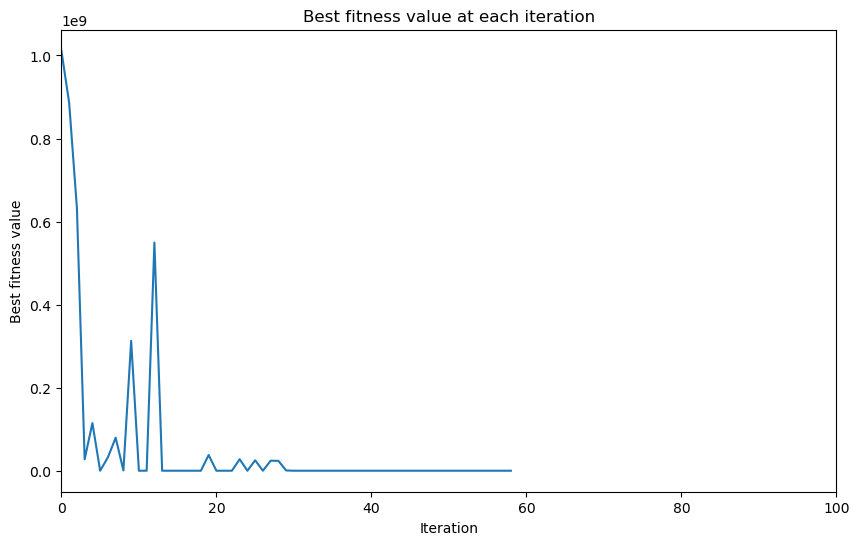

In [16]:
plt.figure(figsize=(10, 6))
plt.plot( bestfit_particle_1, linestyle='-')
plt.xlim(0,100)
plt.xlabel('Iteration')
plt.ylabel('Best fitness value')
plt.title('Best fitness value at each iteration')
plt.show()

In [17]:
print("GBest values: ", global_best_pos_1)
print("GBest values: ", global_best_val_1)
c_PV_rated = 1 #kW
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh
print('Total capacities:','\nPV: ', 1*global_best_pos_1[0]/1000,' MW','\nDE: ', global_best_pos_1[1],' MW' ,'\nBESS: ',global_best_pos_1[2]*c_BESS_rated/1000,' MWh')

GBest values:  [925.   2.   0.]
GBest values:  71724.20895368527
Total capacities: 
PV:  0.925  MW 
DE:  2.0  MW 
BESS:  0.0  MWh


## 1-2- DE

In [18]:
bounds = np.array([[0, 0], [0, 15], [0, 0]])

result2 = PSO(n_particles=6, dimensions=3, bounds=bounds, max_iter=100,
             cognitive_param=2, social_param=2, w_min=0.4, w_max=1, damping_factor=0.9, initial_guess = [0, 2, 0])

Iteration: 1 of 100 Estimated remaining time: 5 minutes and 52 seconds ; Elapsed time:  0  minutes
Iteration: 2 of 100 Estimated remaining time: 3 minutes and 33 seconds ; Elapsed time:  0  minutes
Iteration: 3 of 100 Estimated remaining time: 2 minutes and 46 seconds ; Elapsed time:  0  minutes
Iteration: 4 of 100 Estimated remaining time: 2 minutes and 16 seconds ; Elapsed time:  0  minutes
Iteration: 5 of 100 Estimated remaining time: 1 minutes and 47 seconds ; Elapsed time:  0  minutes
Iteration: 6 of 100 Estimated remaining time: 1 minutes and 28 seconds ; Elapsed time:  0  minutes
Iteration: 7 of 100 Estimated remaining time: 1 minutes and 18 seconds ; Elapsed time:  0  minutes
Iteration: 8 of 100 Estimated remaining time: 1 minutes and 11 seconds ; Elapsed time:  0  minutes
Iteration: 9 of 100 Estimated remaining time: 1 minutes and 2 seconds ; Elapsed time:  0  minutes
Iteration: 10 of 100 Estimated remaining time: 0 minutes and 55 seconds ; Elapsed time:  0  minutes
Iteration:

In [19]:
global_best_pos_2 =result2[0]
global_best_val_2 = result2[1]
global_best_fitness_2 = result2[2]
iteration_positions_2 = result2[3]
best_particle_indices_2 = result2[4]
bestfit_particle_2 = result2[5]

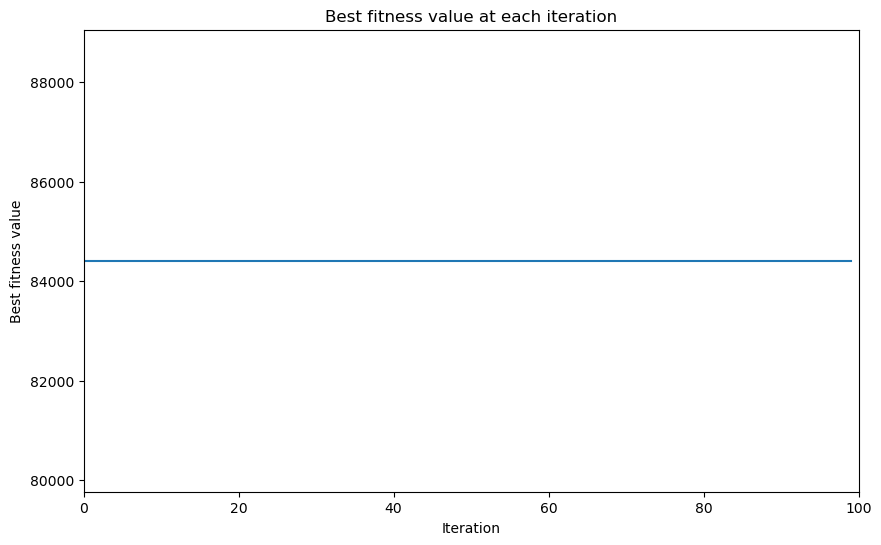

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, 100), global_best_fitness_2, linestyle='-')
plt.xlim(0,100)
plt.xlabel('Iteration')
plt.ylabel('Best fitness value')
plt.title('Best fitness value at each iteration')
plt.show()

In [21]:
print("GBest values: ", global_best_pos_2)
print("GBest values: ", global_best_val_2)
c_PV_rated = 1 #kW
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh
print('Total capacities:','\nPV: ', 10*global_best_pos_2[0],' kW','\nDE: ', global_best_pos_2[1]*1000,' kW' ,'\nBESS: ',global_best_pos_2[2]*30,' kWh')

GBest values:  [0 2 0]
GBest values:  84408.5986133531
Total capacities: 
PV:  0  kW 
DE:  2000  kW 
BESS:  0  kWh


## 1-3- PV+BESS

In [13]:
bounds = np.array([[0, 10000], [0, 0], [0, 30]])

result3 = PSO(n_particles=10, dimensions=3, bounds=bounds, max_iter=150,
              cognitive_param=2, social_param=2, w_min=0.4, w_max=1, damping_factor=0.9, initial_guess = [100, 0, 1])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-19
Iteration: 1 of 150 Estimated remaining time: 16 minutes and 27 seconds ; Elapsed time:  0  minutes
Iteration: 2 of 150 Estimated remaining time: 12 minutes and 11 seconds ; Elapsed time:  0  minutes
Iteration: 3 of 150 Estimated remaining time: 10 minutes and 35 seconds ; Elapsed time:  0  minutes
Iteration: 4 of 150 Estimated remaining time: 9 minutes and 42 seconds ; Elapsed time:  0  minutes
Iteration: 5 of 150 Estimated remaining time: 9 minutes and 13 seconds ; Elapsed time:  0  minutes
Iteration: 6 of 150 Estimated remaining time: 8 minutes and 50 seconds ; Elapsed time:  0  minutes
Iteration: 7 of 150 Estimated remaining time: 8 minutes and 31 seconds ; Elapsed time:  0  minutes
Iteration: 8 of 150 Estimated remaining time: 8 minutes and 17 seconds ; Elapsed time:  0  minutes
Iteration: 9 of 150 Estimated remaining time: 8 minutes and 6 seconds ; Elapsed time:  0  minutes
Iteration: 10 of

In [14]:
global_best_pos_3 =result3[0]
global_best_val_3 = result3[1]
global_best_fitness_3 = result3[2]
iteration_positions_3 = result3[3]
best_particle_indices_3 = result3[4]
bestfit_particle_3 = result3[5]

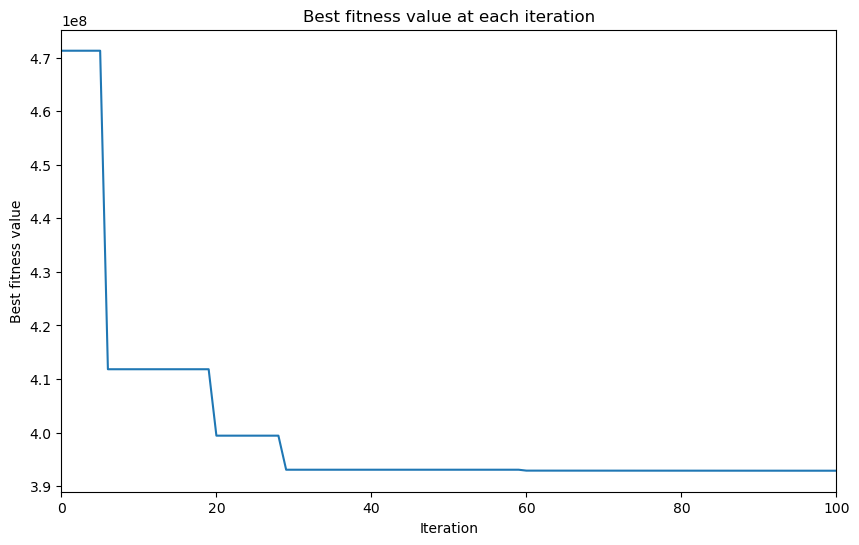

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, 150), global_best_fitness_3, linestyle='-')
plt.xlim(0,100)
plt.xlabel('Iteration')
plt.ylabel('Best fitness value')
plt.title('Best fitness value at each iteration')
plt.show()

In [16]:
print("GBest values: ", global_best_pos_3)
print("GBest values: ", global_best_val_3)
c_PV_rated = 1 #kW
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh
print('Total capacities:','\nPV: ', c_PV_rated*global_best_pos_3[0],' kW','\nDE: ', global_best_pos_3[1]*c_DE_rated,' kW' ,'\nBESS: ',global_best_pos_3[2]*c_BESS_rated,' kWh')

GBest values:  [3936.    0.    7.]
GBest values:  392861727.46050626
Total capacities: 
PV:  3936.0  kW 
DE:  0.0  kW 
BESS:  21000.0  kWh


## 1-4- DE+PV+BESS

In [22]:
bounds = np.array([[0, 9000], [0, 10], [0, 20]])

result4 = PSO(n_particles=10, dimensions=3, bounds=bounds, max_iter=150,
              cognitive_param=2, social_param=2, w_min=0.4, w_max=1, damping_factor=0.9, initial_guess = [100, 5, 5])

Iteration: 1 of 150 Estimated remaining time: 40 minutes and 8 seconds ; Elapsed time:  0  minutes
Iteration: 2 of 150 Estimated remaining time: 31 minutes and 47 seconds ; Elapsed time:  0  minutes
Iteration: 3 of 150 Estimated remaining time: 30 minutes and 40 seconds ; Elapsed time:  0  minutes
Iteration: 4 of 150 Estimated remaining time: 28 minutes and 32 seconds ; Elapsed time:  0  minutes
Iteration: 5 of 150 Estimated remaining time: 27 minutes and 5 seconds ; Elapsed time:  0  minutes
Iteration: 6 of 150 Estimated remaining time: 25 minutes and 32 seconds ; Elapsed time:  1  minutes
Iteration: 7 of 150 Estimated remaining time: 26 minutes and 30 seconds ; Elapsed time:  1  minutes
Iteration: 8 of 150 Estimated remaining time: 24 minutes and 26 seconds ; Elapsed time:  1  minutes
Iteration: 9 of 150 Estimated remaining time: 23 minutes and 40 seconds ; Elapsed time:  1  minutes
Iteration: 10 of 150 Estimated remaining time: 23 minutes and 42 seconds ; Elapsed time:  1  minutes
I

In [23]:
global_best_pos_4 =result4[0]
global_best_val_4 = result4[1]
global_best_fitness_4 = result4[2]
iteration_positions_4 = result4[3]
best_particle_indices_4 = result4[4]
bestfit_particle_4 = result4[5]

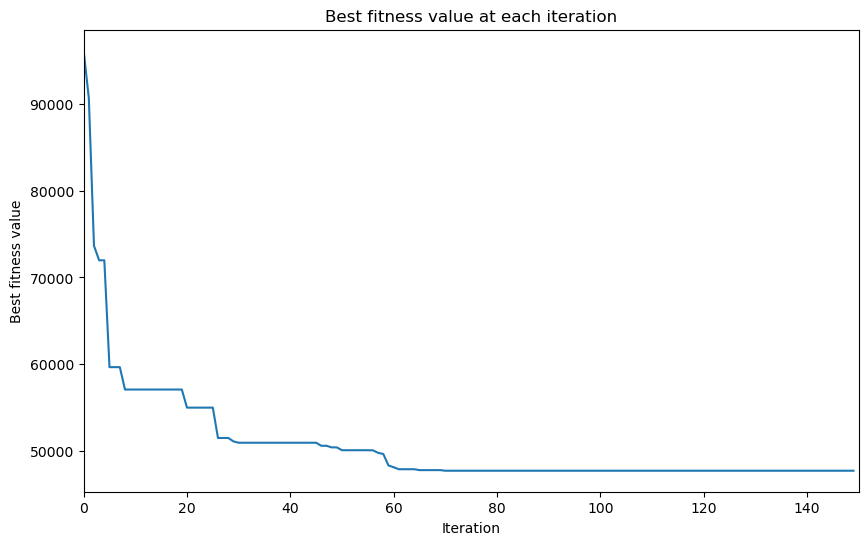

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, 150), global_best_fitness_4, linestyle='-')
plt.xlim(0,150)
plt.xlabel('Iteration')
plt.ylabel('Best fitness value')
plt.title('Best fitness value at each iteration')
plt.show()

In [25]:
print("GBest values: ", global_best_pos_4)
print("GBest values: ", global_best_val_4)
c_PV_rated = 1 #kW
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh
print('Total capacities:','\nPV: ', c_PV_rated *global_best_pos_4[0],' kW','\nDE: ', global_best_pos_4[1] * c_DE_rated,' kW' ,'\nBESS: ',global_best_pos_4[2] * c_BESS_rated,' kWh')

GBest values:  [3.623e+03 1.000e+00 4.000e+00]
GBest values:  47696.52196648315
Total capacities: 
PV:  3623.0  kW 
DE:  1000.0  kW 
BESS:  12000.0  kWh
